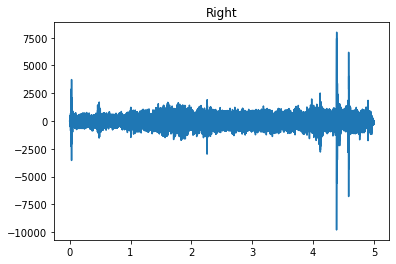

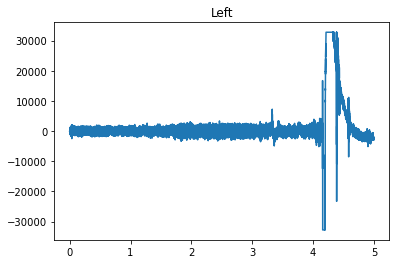

In [10]:
import sounddevice as sd
import soundfile as sf
import threading
import time
#permet d'afficher un son
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour générer un signal de bruit blanc
def generate_white_noise(duration, sample_rate):
    samples = np.random.normal(0, 1, int(duration * sample_rate))
    return samples

# Fonction pour générer une sinusoïde de 440 Hz
def generate_sine_wave(duration, sample_rate):
    frequency = 440  # Hz
    samples = (np.sin(2 * np.pi * np.arange(sample_rate * duration) * frequency / sample_rate)).astype(np.float32)
    return samples

def generate_clap(sample_rate):
    t = np.linspace(0,1,int(sample_rate),endpoint=False)
    zeros = np.zeros(3*sample_rate)
    handclap=np.sin(2*np.pi*1000*t)*np.exp(-5*t)
    return np.concatenate((zeros,handclap))

# Fonction pour lire le signal sur les haut-parleurs
def play_signal(signal, sample_rate):
    sd.play(signal, sample_rate)
    sd.wait()

# Fonction pour enregistrer le son du microphone
def record_microphone():
    duration = 5  # Durée de l'enregistrement en secondes
    sample_rate = 44100  # Fréquence d'échantillonnage en Hz
    channels = 2
    # Demander à l'utilisateur de choisir le type de signal à générer
    signal_type = input("Entrez le type de signal à générer (1 : blanc | 2 : sinus | 3 : clap) : ")

    if signal_type == "1":
        signal = generate_white_noise(duration, sample_rate)
    elif signal_type == "2":
        signal = generate_sine_wave(duration, sample_rate)
    elif signal_type == "3":
        signal = generate_clap(sample_rate)
    else:
        print("Type de signal non reconnu.")
        return

    # Démarrer un thread pour lire le signal sur les haut-parleurs
    play_thread = threading.Thread(target=play_signal, args=(signal, sample_rate))
    play_thread.start()

    # Enregistrer le son du microphone dans un fichier WAV
    recorded_audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels)
    sd.wait()  # Attendre la fin de l'enregistrement
    # Enregistrer les données audio dans un fichier WAV
    file_name = "enregistrement.wav"
    sf.write(file_name, recorded_audio, sample_rate, subtype='PCM_16')
    # Attendre la fin de la lecture du signal sur les haut-parleurs
    play_thread.join()

# Démarrer un thread pour enregistrer le son du microphone et un autre thread pour jouer le signal en même temps
record_thread = threading.Thread(target=record_microphone)
record_thread.start()

# Attendre la fin des deux threads
record_thread.join()

# Charger le fichier audio
rate, data = scipy.io.wavfile.read('enregistrement.wav')


N=len(data) #nombre d'échantillions 
n = np.arange(0,N)/44100   #on divise par la fréquence d'échantillonage pour etre mieux dans l'échelle 

data_right = data[:,1]
data_left = data[:,0]


#affichage du channel 1 
plt.figure()
plt.title("Right")
plt.plot(n,data_right)
plt.figure()
plt.title("Left")
plt.plot(n,data_left)

#plt.ylim(-10000,10000)
plt.show()


